# Project INF8225: tutorial
**Knockoff Nets: Stealing Functionality of Black-Box Models, CVPR '19** 

This part presents the efforts done to reproduce the results of the paper and the additional work by our team.

**Challenges faced:** Although the authors provide a Github repository with their code, the reproduction of the results tooks us a lot of time (weeks) since the attacks are against complex models (ResNet-38, VGG-16,..) and the datasets are huge. The Readme written does not provide enough information and requires a good knowledge and experience in deep learning programming.

The forked repository for the project is on this link: https://github.com/KacemKhaled/knockoffnets


# Environment Preparation
**Disclaimer:** if you are using Windows, you may not be able to prepare the environment, we tried that for a while and it only lead us to *Errors Land*! So save your time and use Linux. In our case, we used Ubuntu 16.04.

#### Before you start: Setting up the GPU
The process to install the CUDA driver on Linux is complicated and time consuming, but it is worth it to gain more time in the future instead of working on the CPU. 

We have followed this tutorial: https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html


## Steps 


*   Fork the original repository from : https://github.com/tribhuvanesh/knockoffnets, our forked repository is on this link: https://github.com/KacemKhaled/knockoffnets
*   Clone it into your own machine: 

```
$ git clone https://github.com/KacemKhaled/knockoffnets.git
```
*   If you don't have Anaconda installed, it would be better to install it (https://conda.io/projects/conda/en/latest/user-guide/install/linux.html)
*   Go to the repository and execute 

```
$ conda env create -f environment.yml
```

*   This should install all the requirements and create a conda enivornment, to start working in the project you should activate the environment (named "knockoff") using this command:

```
$ conda activate knockoff
```


# Experiments

### Attack: Overview

Following the content of the Readme Page the commands/steps provided will guide you to:

1. Train victim models (or download pretrained ResNet-34 models)
2. Train knockoff models (or download pretrained ResNet-34 models)
  * Constructing transfer sets
  * Training knockoff models

The framework provided by the authors is rich with predefined commands to run most of the experiments and reproduce them. However, training complicated architectures need a lot of GPU time. So we decided to reproduce the steps once for only one victim with different architecture to assess the expandability of the attacks.

### 1. Training Victim model
We have chosen a Resnet-18 architecture instead of Resnet-34 to train the victim model on CUBS200 dataset.

```
# Format:
$ python -m "knockoff.victim.train" DS_NAME ARCH -d DEV_ID \
        -o models/victim/VIC_DIR -e EPOCHS --pretrained
# where DS_NAME = {cubs200, caltech256, ...}, ARCH = {resnet18, vgg16, densenet161, ...}
# if the machine contains multiple GPUs, DEV_ID specifies which GPU to use

# We run this command
$ python -m "knockoff.victim.train" CUBS200 resnet18 -d 0 \
        -o models/victim/cubs200-resnet18 -e 10 --log-interval 25 \
        --pretrained imagenet
```
(we added the output files to the github repository in the folder ./files/victim/cubs200-resnet18):



In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

PATH = "drive/My Drive/1 Polymtl/Hiv20/INF8225/Project/" # change the path to the folder "files"
logs = pd.read_csv(PATH + "train.log.tsv", sep='\t')
train_logs = logs.loc[logs['split']=='train'].reset_index(drop=True)
test_logs = logs.loc[logs['split']=='test'].reset_index(drop=True)

In [172]:
train_logs

,run_id,epoch,split,loss,accuracy,best_accuracy
0,2020-04-25 19:06:02.007020,1,train,0.061053,16.349683,16.349683
1,2020-04-25 19:06:02.007020,2,train,0.037798,39.189189,39.189189
2,2020-04-25 19:06:02.007020,3,train,0.031709,47.664331,47.664331
3,2020-04-25 19:06:02.007020,4,train,0.027583,54.154154,54.154154
4,2020-04-25 19:06:02.007020,5,train,0.025004,57.991325,57.991325
5,2020-04-25 19:06:02.007020,6,train,0.023533,60.477144,60.477144
6,2020-04-25 19:06:02.007020,7,train,0.022039,62.929596,62.929596
7,2020-04-25 19:06:02.007020,8,train,0.020205,65.565566,65.565566
8,2020-04-25 19:06:02.007020,9,train,0.020203,66.016016,66.016016
9,2020-04-25 19:06:02.007020,10,train,0.018603,68.735402,68.735402


In [173]:
test_logs

,run_id,epoch,split,loss,accuracy,best_accuracy
0,2020-04-25 19:06:02.007020,1,test,0.048214,26.630998,26.630998
1,2020-04-25 19:06:02.007020,2,test,0.039005,36.727649,36.727649
2,2020-04-25 19:06:02.007020,3,test,0.032614,44.787711,44.787711
3,2020-04-25 19:06:02.007020,4,test,0.034341,42.958233,44.787711
4,2020-04-25 19:06:02.007020,5,test,0.034713,44.943045,44.943045
5,2020-04-25 19:06:02.007020,6,test,0.028313,53.348291,53.348291
6,2020-04-25 19:06:02.007020,7,test,0.028577,54.055920,54.055920
7,2020-04-25 19:06:02.007020,8,test,0.028043,52.364515,54.055920
8,2020-04-25 19:06:02.007020,9,test,0.027822,55.522955,55.522955
9,2020-04-25 19:06:02.007020,10,test,0.032350,49.447705,55.522955


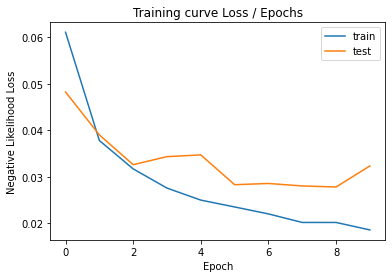

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


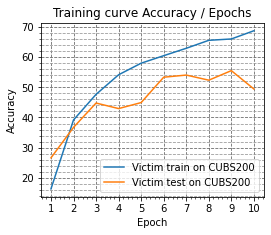

In [174]:
import matplotlib.pyplot as plt

# collect and plot the losses for the training and test sets
accuracy = train_logs['accuracy']
loss = train_logs[ 'loss']
test_accuracy = test_logs['accuracy']
test_loss = test_logs['loss']
epoch = train_logs['epoch']

plt.figure()
plt.plot(loss, label="train")
plt.plot(test_loss, label="test")
plt.title('Training curve Loss / Epochs')
plt.ylabel('Negative Likelihood Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(4, 3.2))
plt.plot(epoch,accuracy, label="Victim train on CUBS200")
plt.plot(epoch,test_accuracy, label="Victim test on CUBS200")
plt.title('Training curve Accuracy / Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epoch)
plt.legend(loc='best')
plt.grid(b=True, which='major', color='#666666', linestyle='dashed')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='dashed',axis='y')
plt.savefig(PATH+"victim-resnet-18.eps",format="eps")
plt.show()

### 2.1. Constructing transfer sets
The chosen dataset to construct the transfer set in the original code is ImageNet, we have attempted to download it from the official website but our request to the organization is still pending. So we decided to use a part of the OpenImages dataset (only 58GB which is around 160k images). 

Handling the OpenImages dataset was not included in the project code so we added the necessary modifications for the purpose.

Then we executed this command to query 80k images from the dataset to the victim model with a random policy.

```
# Format
$ python -m "knockoff.adversary.transfer" random models/victim/VIC_DIR \
        --out_dir models/adversary/ADV_DIR --budget BUDGET \
        --queryset QUERY_SET --batch_size 8 -d DEV_ID
# where QUERY_SET = {ImageNet1k , OpenImages...}

# We run this command
$ python3 -m "knockoff.adversary.transfer" random models/victim/cubs200-resnet18 \
        --out_dir models/adversary/cubs200-resnet18-random --budget 80000 \
        --queryset OpenImages --batch_size 8 -d 0
```
We obtained as output after 1 hour and 51 minutes (we added the file to the github repository in the folder ./files/adversary/cubs200-resnet18-random):
```
=> done loading OpenImages (train) with 160000 examples
=> loading checkpoint 'models/victim/cubs200-resnet18/checkpoint.pth.tar'
=> loaded checkpoint (epoch 9, acc=55.52)
=> constructing transfer set...
100%|███████████████████████████████████| 80000/80000 [1:51:36<00:00, 17.40it/s]
=> transfer set (80000 samples) written to: models/adversary/cubs200-resnet18-random/transferset.pickle
```

In [0]:
transferset = pd.read_pickle(PATH+"transferset.pickle")

In [176]:
import numpy as np
# read classes
classes = pd.read_csv(PATH+"classes.txt",sep=' ',names=['label'], index_col=0)
merge = np.array([])


# example of an element from the transferset
print(transferset[0])

# examples to choose
examples= []
for i in range(200):
  maxpred= np.max(np.array(transferset[i][1]))
  examples.append(maxpred)
top_predictions = np.array(examples)
idx_examples = (-top_predictions).argsort()[:5]
print('indexes: ', idx_examples)
print('top predictions:', top_predictions[idx_examples])


print("\n4 Examples of images with their top 3 lables:")

for x in idx_examples:
  i = int(x)
  print("\nExample #",i)
  print("image path:"+str(transferset[i][0]))
  predictions = np.array(transferset[i][1])
  idx = (-predictions).argsort()[:4]
  idx = idx[idx != 0]
  print('indexes: ', idx)
  print('predictions:', predictions[idx])
  print(classes.loc[idx,['label']])



('/media/kacem/2E86F7E186F7A80B/Users/KACEM/Desktop/KACEM/PolyMt/hiver20/INF8225/projet/forks/knockoffnets/knockoff/datasets/openImages/openimages/f7bc2ad84474c7ad.jpg', tensor([6.1574e-04, 9.2191e-05, 8.2578e-05, 6.2094e-02, 6.5492e-06, 6.5040e-05,
        6.0312e-06, 6.8441e-05, 1.4557e-02, 4.3083e-03, 1.3109e-02, 7.2825e-03,
        3.4376e-04, 3.6292e-05, 1.8468e-04, 1.7720e-05, 3.3460e-04, 3.1850e-04,
        3.1472e-04, 3.2857e-04, 2.0242e-04, 3.9368e-04, 8.8079e-03, 3.3653e-04,
        7.7875e-04, 1.0358e-02, 3.4384e-03, 3.3639e-05, 2.1800e-02, 1.2728e-02,
        3.5984e-05, 1.1218e-04, 2.4604e-04, 1.1521e-02, 9.8124e-05, 5.5131e-03,
        9.7499e-06, 1.1501e-03, 8.0259e-06, 3.2196e-05, 7.6638e-04, 3.1307e-03,
        2.0702e-05, 3.1769e-05, 6.7404e-06, 5.3036e-03, 5.0345e-04, 2.8303e-03,
        2.9574e-03, 1.2044e-04, 5.0459e-04, 1.1939e-03, 2.4962e-04, 1.1548e-03,
        2.7466e-03, 3.7861e-05, 2.1143e-05, 2.9952e-04, 1.9919e-03, 5.1227e-05,
        1.2916e-02, 3.0619e-04


### 2.2. Training the Knockoff model
The obtained transfer set will serve as a dataset to train a knockoff model, here we decided to train the model on an architecture different that the victim which had ResNet-18, so we chose ResNet-34.

We tried to train on different architectures like Inception, DenseNet and AlexNet, but the pytorch implementation of the project was not able to finish because of lack of GPU memory. After debugging efforts, these issues need **major code refactoring**. This may be explained by the last update made by the authors on the pytorch version of the code which caused these bugs that will require more handling.


```
# Format:
$ python -m "knockoff.adversary.train" models/adversary/ADV_DIR ARCH DS_NAME \
        --budgets BUDGET1,BUDGET2,.. -d DEV_ID --pretrained --epochs EPOCHS \
        --lr LR
# DS_NAME refers to the dataset used to train victim model; used only to evaluate on test set during training of knockoff


# We run this command
$ python3 -m "knockoff.adversary.train" models/adversary/cubs200-resnet18-random \
        resnet34 CUBS200 --budgets 80000 -d 0 --pretrained imagenet \
        --log-interval 100 --epochs 10 --lr 0.01 
```


In [0]:
PATH = "drive/My Drive/1 Polymtl/Hiv20/INF8225/Project/" # changer le path avec votre path
logs_adv = pd.read_csv(PATH + "train.80000.log.tsv", sep='\t')
train_logs_adv = logs_adv.loc[logs_adv['split']=='train'].reset_index(drop=True)
test_logs_adv = logs_adv.loc[logs_adv['split']=='test'].reset_index(drop=True)

In [178]:
train_logs_adv

,run_id,epoch,split,loss,accuracy,best_accuracy
0,2020-04-26 17:46:35.749177,1,train,0.060917,35.35500,35.35500
1,2020-04-26 17:46:35.749177,2,train,0.055538,46.47875,46.47875
2,2020-04-26 17:46:35.749177,3,train,0.053972,51.15625,51.15625
3,2020-04-26 17:46:35.749177,4,train,0.053116,54.14250,54.14250
4,2020-04-26 17:46:35.749177,5,train,0.052527,56.38000,56.38000
5,2020-04-26 17:46:35.749177,6,train,0.052063,58.30000,58.30000
6,2020-04-26 17:46:35.749177,7,train,0.051705,60.00750,60.00750
7,2020-04-26 17:46:35.749177,8,train,0.051415,61.54125,61.54125
8,2020-04-26 17:46:35.749177,9,train,0.051175,62.78375,62.78375
9,2020-04-26 17:46:35.749177,10,train,0.050957,63.94750,63.94750


In [179]:
test_logs_adv

,run_id,epoch,split,loss,accuracy,best_accuracy
0,2020-04-26 17:46:35.749177,1,test,0.074251,11.097687,11.097687
1,2020-04-26 17:46:35.749177,2,test,0.063751,18.967898,18.967898
2,2020-04-26 17:46:35.749177,3,test,0.058677,22.540559,22.540559
3,2020-04-26 17:46:35.749177,4,test,0.055457,24.197446,24.197446
4,2020-04-26 17:46:35.749177,5,test,0.052155,27.217812,27.217812
5,2020-04-26 17:46:35.749177,6,test,0.050352,28.477736,28.477736
6,2020-04-26 17:46:35.749177,7,test,0.048844,30.048326,30.048326
7,2020-04-26 17:46:35.749177,8,test,0.046681,31.256472,31.256472
8,2020-04-26 17:46:35.749177,9,test,0.045904,31.998619,31.998619
9,2020-04-26 17:46:35.749177,10,test,0.044576,33.344839,33.344839


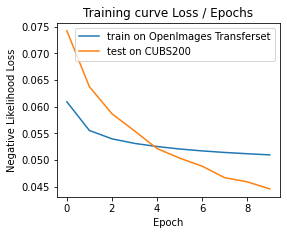

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


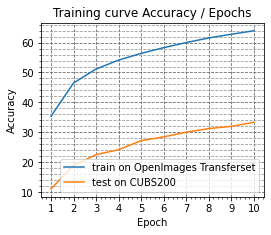

In [180]:
# collect and plot the losses for the training and test sets
accuracy_adv = train_logs_adv['accuracy']
loss_adv = train_logs_adv[ 'loss']
test_accuracy_adv = test_logs_adv['accuracy']
test_loss_adv = test_logs_adv['loss']
epoch = train_logs_adv['epoch']

plt.figure(figsize=(4, 3.2))
plt.plot(loss_adv, label="train on OpenImages Transferset")
plt.plot(test_loss_adv, label="test on CUBS200")
plt.title('Training curve Loss / Epochs')
plt.ylabel('Negative Likelihood Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(4, 3.2))
plt.plot(epoch,accuracy_adv, label="train on OpenImages Transferset")
plt.plot(epoch,test_accuracy_adv, label="test on CUBS200")
plt.title('Training curve Accuracy / Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epoch)
plt.legend(loc='best')
plt.grid(b=True, which='major', color='#666666', linestyle='dashed')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='dashed',axis='y')
plt.savefig(PATH+"knockoff-resnet-18.eps",format="eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


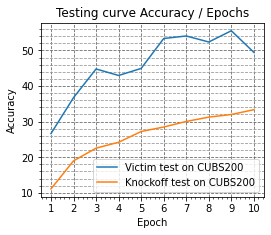

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


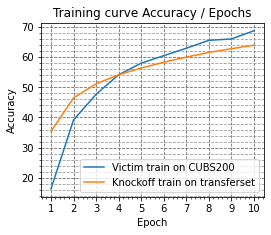

In [181]:
plt.figure(figsize=(4, 3.2))
plt.plot(epoch,test_accuracy, label="Victim test on CUBS200")
plt.plot(epoch,test_accuracy_adv, label="Knockoff test on CUBS200")
plt.title('Testing curve Accuracy / Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epoch)
plt.legend(loc='best')
plt.grid(b=True, which='major', color='#666666', linestyle='dashed')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='dashed',axis='y')
plt.savefig(PATH+"victim-knockoff-test-resnet-18.eps",format="eps")
plt.show()

plt.figure(figsize=(4, 3.2))
plt.plot(epoch,accuracy, label="Victim train on CUBS200")
plt.plot(epoch,accuracy_adv, label="Knockoff train on transferset")
plt.title('Training curve Accuracy / Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epoch)
plt.legend(loc='best')
plt.grid(b=True, which='major', color='#666666', linestyle='dashed')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='dashed',axis='y')
plt.savefig(PATH+"victim-knockoff-train-resnet-18.eps",format="eps")
plt.show()

# Reproduction of the KnockoffNets attack using Adversarial Robustness Toolbox

After forking the library from https://github.com/IBM/adversarial-robustness-toolbox/  and setting up the GPU environment, the next step is installing ART with the following command from the project folder adversarial-robustness-toolbox:

```
pip install .
```
The files **knockoff_nets.py** and **test_knockoff_nets.py** are our focus in order to reproduce the results. It would be better to use PyCharm, since the files are divided into cells that you can run seperately.

We performed two attacks: one against a model trained on MNIST dataset and the other against a model trained on IRIS dataset.
